## FAQ
* Как использовать: Рекомендуется использование платформы Google.Colab. Разместите в одной директории с файлом ноутбука файл весов, после чего поочередно запускайте фрагменты
* Тестирование: Для тестирование выполните все фрагменты до Предварительных работ включительно, после чего запустите фрагмент Тестирование
### Возможные проблемы:
* Решение не набирает 200 очков: проверьте загрузились ли веса (если нет, то выдаст сообщение "There isnt old weights"), если веса загружены, то проверьте тип девайса (выводится под фрагментом №2), решение может набирать ~190 баллов, если решение запущено на CPU, в таком случае используйте  Google.Colab для запуска решения на GPU (cuda). Причина последней проблемы не известна, возможно проблема с преобразованием GPU весов в CUDA весов
* "IsLocked" - перезапустите блок инициализации среды
* "There isnt old weights" - файл с весами не найден, проверьте название файла и дирректорию в которой он находится
* "Your session crashed for an unknown reason" - просто заново запустите каждый фрагмент




# Double Deep Q-Network 
---


## 1. Установка необходимых для работы в Google.Colab пакетов##

In [0]:
!apt install xvfb
!apt install cuda

!pip install box2d-py
!pip install torch
!pip install torchvision
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cuda is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


##2. Импортируем пакеты##
В результате выполнения после блока будет выведен тип девайса на котором будет работать/тренироваться алгоритм. Если вы работаете в Google.Colab вы можете изменить тип девайса в вкладке Runtime -> Change Runtime Type


In [1]:
%matplotlib inline

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import matplotlib
from collections import namedtuple
from itertools import count
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from pyvirtualdisplay import Display

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display as ds

plt.ion()

display = Display(visible=0, size=(1400, 900))
display.start()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##3. Инициализируем среду##

In [0]:
gym.logger.set_level(40)

env = gym.make('LunarLander-v2').unwrapped

##4. Объявляем класс ReplayMemory, в котором будем хранить переходы из одного состояния в другое, действие, награду и состояние завершения эпизода##

In [0]:
class ReplayMemory:

    def __init__(self, buffer_size, batch_size, seed):

        self.action_size = 4
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "next_state", "reward", "done"])
        self.seed = random.seed(seed)
    
    def push(self, state, action, next_state, reward, done):

        e = self.experience(state, action, next_state, reward, done)
        self.memory.append(e)
    
    def sample(self):

        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, next_states, rewards, dones)

    def __len__(self):

        return len(self.memory)

##5. Объявляем класс нейросети##
На входном слое объявляем 8 нейронов, на 2 скрытых по 64 и 4 класса на выходе согласно количеству действий

In [0]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()  
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, 4)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        action = self.fc_out(out)
        
        return action

##6. Предварительные работы ##
Объявляем константы, 2 экземпляра нейросети, копируем веса, и один переводим в режим оценки. Объявляем функцию выбора действия, переводим основную нейросеть в режжим оценки, выбираем действие, после чего возвращаем в режим обучения.

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 100000
GAMMA = .99
EPS_START = .9
EPS_END = .05
EPS_DECAY = .995
LR =0.0016

policy_net = DQN().to(device)
target_net = DQN().to(device)
try:
  policy_net.load_state_dict(torch.load("./model_mse_loss(super).nn", map_location=device))
except:
  print("There isnt old weights")
  
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

memory = ReplayMemory(buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=0)
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

steps_done = 0

def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            policy_net.eval()
            result = policy_net(state)
            policy_net.train()
            return np.argmax(result.cpu().data.numpy())
            
    else:
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)

def test():
    test_rewards = []
    for i in range(100):
        state = env.reset()
        rewards=0
        for j in count():
            action = select_action(torch.FloatTensor(state).to(device), eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * i / EPS_DECAY))
            state, reward, done, _ = env.step(action.item())
            rewards+=reward
    #         env.render()
            if done:
                break 
        test_rewards.append(rewards)       
    env.close()
    return np.mean(test_rewards)

##7. Модель оптимизации (коррекции) весов нейросети
Из памяти получаем пакет переходов, с помощью этих данных определяем Q_targets и Q_expected (целевое и ожидаемое значение Q функции), находим квадратичную ошибку и корректируем веса

In [0]:
def optimize_model():
    
    experiences = memory.sample()
    states, actions, next_states, rewards, dones = experiences
    
    Q_argmax = target_net(torch.tensor(next_states).to(device)).detach()
    _, a_prime = Q_argmax.max(1)

    Q_targets_next = target_net(torch.tensor(next_states).to(device)).detach().gather(1, a_prime.unsqueeze(1))

    Q_targets = torch.tensor(rewards).to(device) + (GAMMA * Q_targets_next * (1 - torch.tensor(dones).to(device)))

    Q_expected = policy_net( torch.tensor(states).to(device)).gather(1, torch.tensor(actions).to(device))

    loss = F.mse_loss(Q_targets, Q_expected)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

##8. Обучение
Обучаем нейросеть и считаем среднее значение за каждые 100 эпизодов. Каждые 100 эпизодов сохраняем веса

In [0]:
eps_threshold = EPS_START
just_rewards = [0]
lr=LR
all_rewards = []
for i_episode in count():
      
    state = env.reset()

    rew_per_episode = 0
    for t in count():
          
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        action = select_action(torch.FloatTensor(state).to(device), eps_threshold)
        next_state, env_reward, done, _ = env.step(action.item())

        rew_per_episode += env_reward
        if (t > 400) & (action.item()!=0):
            env_reward-=0.3
            
        memory.push(state, action.item(), next_state, env_reward, done)

        state = next_state

        if len(memory) >= BATCH_SIZE:
            optimize_model()
        if done:
            all_rewards.append(rew_per_episode)
            just_rewards.append(rew_per_episode)
            break
        if(t%4==0):
          target_net.load_state_dict(policy_net.state_dict())

    print('\rEpisode {} \tLearning rate {:.6f} \tAverage Score: {:.2f}'.format(i_episode+1, lr, np.mean(just_rewards)), end="")
    if((i_episode+1)%100==0):
        print('\rEpisode {} \tLearning rate {:.6f} \tAverage Score: {:.2f}'.format(i_episode+1, lr, np.mean(just_rewards)))
        just_rewards = []
        lr=LR/(i_episode+1)*100
        torch.save(policy_net.state_dict(), "model_mse_loss.nn")
        optimizer = optim.Adam(policy_net.parameters(), lr=lr)
        if(np.mean(just_rewards)>=195):
          test_count = 0
          for test_i in range(3):
              test_mark = test()
              print(test_mark)
              if(test_mark>=195):
                  test_count+=1
          if(test_count>2):
              break
env.close()
plt.figure
plt.show() 

## Тестирование

In [6]:
tested = test()
print('\rAverage score is: {:.2f}'.format(tested))

Average score is: 223.81


## Позалипать на агента :3

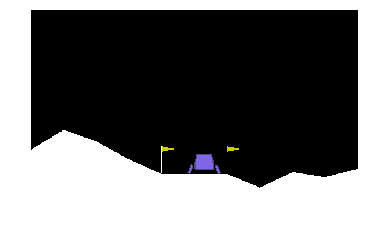

In [7]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in count():
    action = select_action(torch.FloatTensor(state).to(device), eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * i / EPS_DECAY))
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    ds.display(plt.gcf())
    ds.clear_output(wait=True)
    state, reward, done, _ = env.step(action.item())
    if done:
        break